In [4]:
%matplotlib inline
import warnings; warnings.simplefilter('ignore')  # hide warnings

# standard libraries
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sb

# modules from particles
import particles  # core module
from particles import distributions as dists  # where probability distributions are defined
from particles import state_space_models as ssm  # where state-space models are defined

In [3]:
class StochVol(ssm.StateSpaceModel):
    def PX0(self):  # Distribution of X_0
        return dists.Normal(loc=self.mu, scale=self.sigma / np.sqrt(1. - self.rho**2))
    def PX(self, t, xp):  # Distribution of X_t given X_{t-1}=xp (p=past)
        return dists.Normal(loc=self.mu + self.rho * (xp - self.mu), scale=self.sigma)
    def PY(self, t, xp, x):  # Distribution of Y_t given X_t=x (and possibly X_{t-1}=xp)
        return dists.Normal(loc=0., scale=np.exp(x))

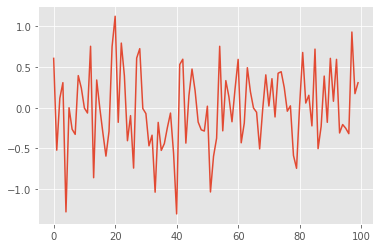

In [5]:
my_model = StochVol(mu=-1., rho=.9, sigma=.1)  # actual model
true_states, data = my_model.simulate(100)  # we simulate from the model 100 data points

plt.style.use('ggplot')
plt.figure()
plt.plot(data)


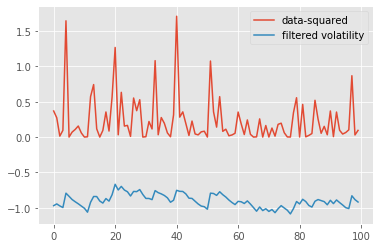

In [6]:
fk_model = ssm.Bootstrap(ssm=my_model, data=data)  # we use the Bootstrap filter
pf = particles.SMC(fk=fk_model, N=100, resampling='stratified', moments=True, store_history=True)  # the algorithm
pf.run()  # actual computation

# plot
plt.figure()
plt.plot([yt**2 for yt in data], label='data-squared')
plt.plot([m['mean'] for m in pf.summaries.moments], label='filtered volatility')
plt.legend()

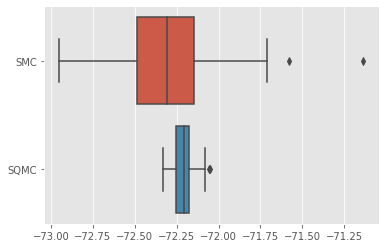

In [7]:
results = particles.multiSMC(fk=fk_model, N=100, nruns=30, qmc={'SMC':False, 'SQMC':True})
plt.figure()
sb.boxplot(x=[r['output'].logLt for r in results], y=[r['qmc'] for r in results])
